In [27]:
import tensorflow as tf
print(tf.__version__)

2.2.0


### Step 1. Dataset Download

In [28]:
import tensorflow_datasets as tfds


In [29]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [30]:
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


### step2 .Dataset type transform to modelling

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

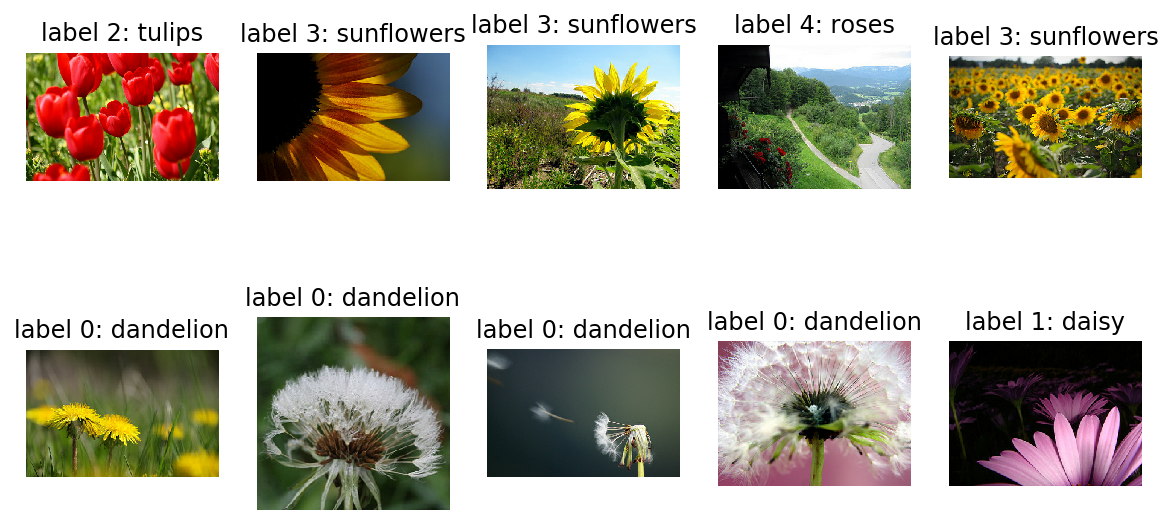

In [32]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [33]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [34]:
import tensorflow as tf

train_batches = raw_train.map(format_example)
validation_batches = raw_validation.map(format_example)
test_batches = raw_test.map(format_example)


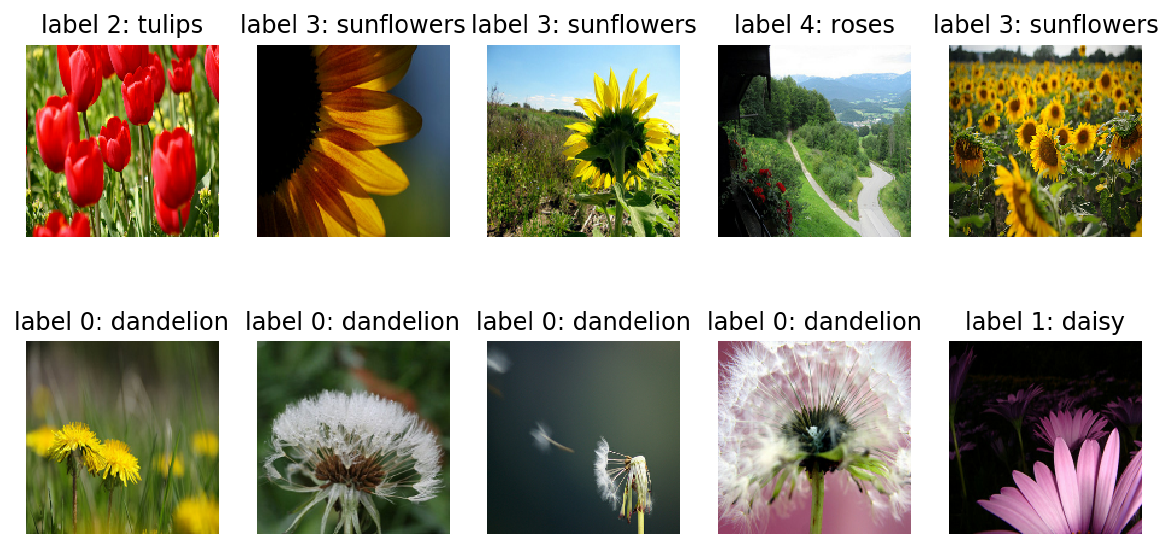

In [35]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train_batches.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### Step3. Model Planning

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D

In [37]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(units=5, activation='softmax')
])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 128)      

In [39]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [40]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [41]:
train_batches = train_batches.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation_batches.batch(BATCH_SIZE)
test_batches = test_batches.batch(BATCH_SIZE)

In [42]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [43]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/20 [===============>..............] - ETA: 0s - loss: 1.6167 - accuracy: 0.1392WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


12/20 [=================>............] - 0s 33ms/step - loss: 1.6175 - accuracy: 0.1390
initial loss: 1.62
initial accuracy: 0.14


In [44]:
EPOCHS = 20
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 15s 164ms/step - loss: 1.5177 - accuracy: 0.3225 - val_loss: 1.3961 - val_accuracy: 0.3978
Epoch 2/20
92/92 [==============================] - 15s 167ms/step - loss: 1.3553 - accuracy: 0.4203 - val_loss: 1.2310 - val_accuracy: 0.5041
Epoch 3/20
92/92 [==============================] - 16s 174ms/step - loss: 1.2581 - accuracy: 0.4802 - val_loss: 1.0997 - val_accuracy: 0.5613
Epoch 4/20
92/92 [==============================] - 15s 167ms/step - loss: 1.1787 - accuracy: 0.5286 - val_loss: 1.1013 - val_accuracy: 0.5668
Epoch 5/20
92/92 [==============================] - 16s 174ms/step - loss: 1.1349 - accuracy: 0.5477 - val_loss: 1.1125 - val_accuracy: 0.5313
Epoch 6/20
92/92 [==============================] - 16s 173ms/step - loss: 1.1032 - accuracy: 0.5668 - val_loss: 1.0759 - val_accuracy: 0.5477
Epoch 7/20
92/92 [==============================] - 16s 170ms/step - loss: 1.0731 - accuracy: 0.5814 - val_loss: 1.0325 - val_accuracy: 0.5668

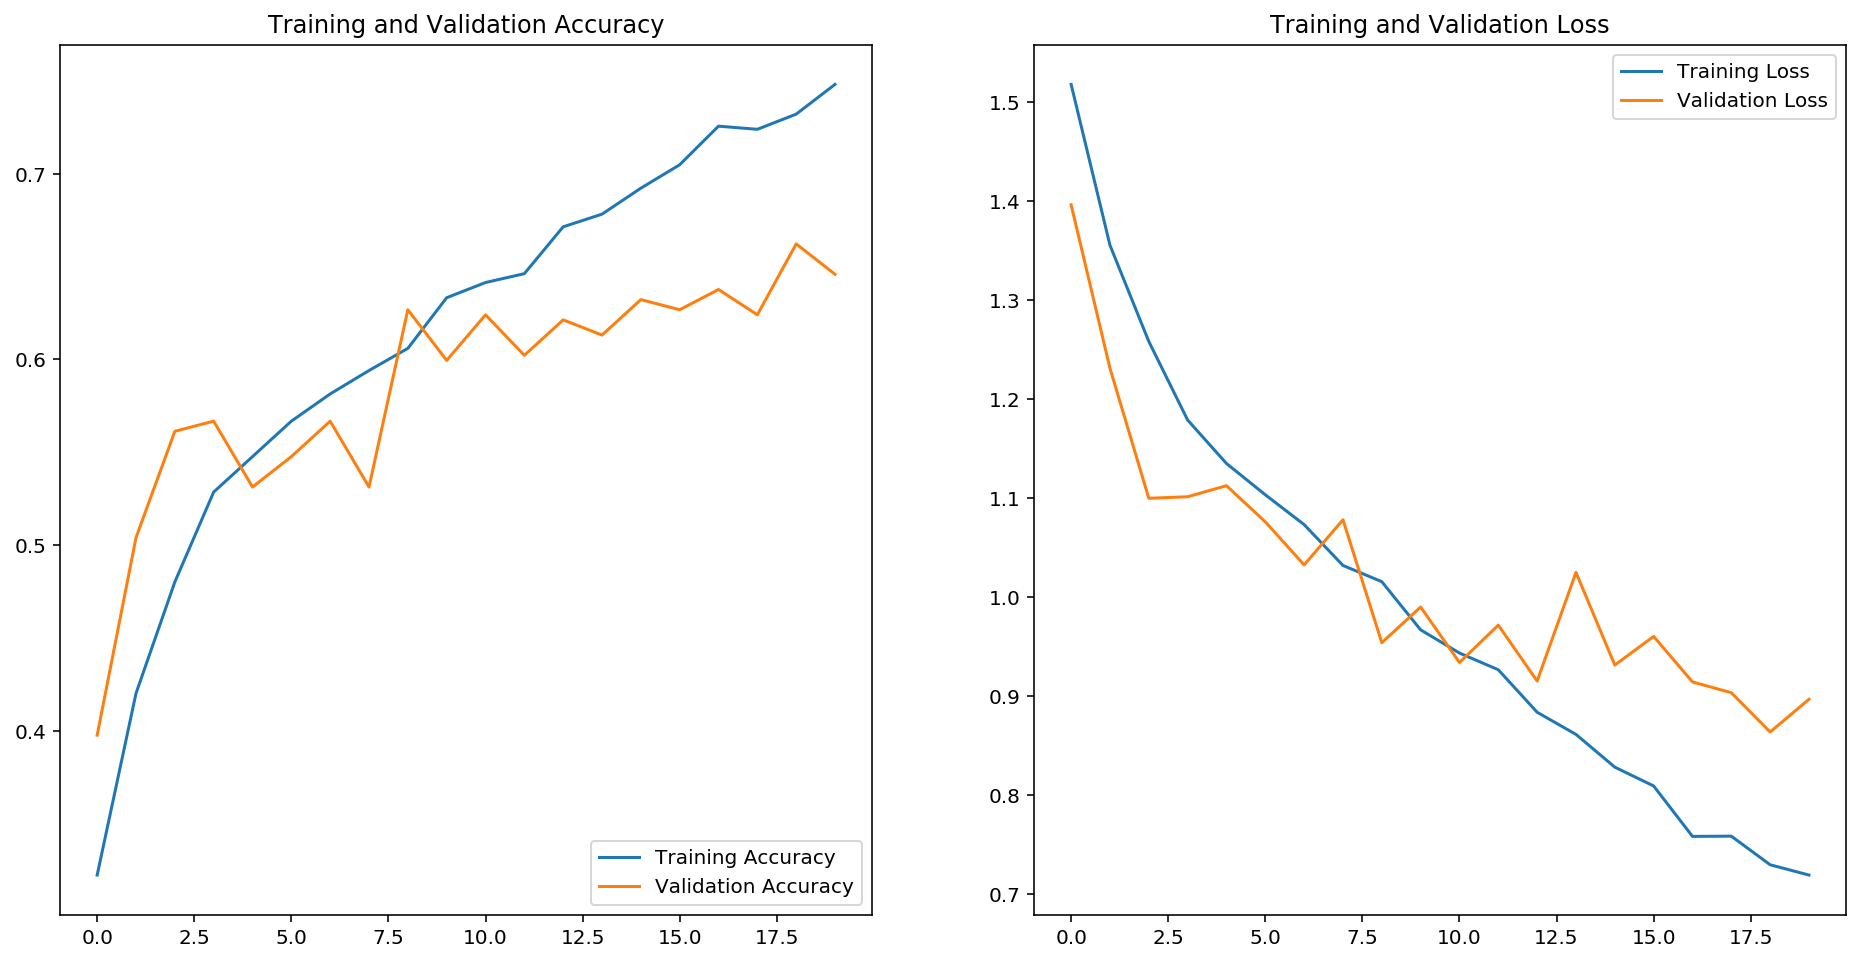

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[8.76304321e-03, 1.14502320e-02, 3.51296037e-01, 7.77245685e-02,
        5.50766170e-01],
       [8.42938542e-01, 1.28796652e-01, 1.65744941e-03, 9.75004223e-05,
        2.65099183e-02],
       [1.45413026e-01, 4.65849265e-02, 2.45233417e-01, 5.48053145e-01,
        1.47155169e-02],
       [1.03946745e-01, 7.59057626e-02, 3.92891288e-01, 3.76771986e-02,
        3.89579028e-01],
       [8.25062692e-01, 5.84082827e-02, 8.04071501e-03, 1.35730417e-03,
        1.07130960e-01],
       [2.34687433e-01, 5.32389164e-01, 8.65688547e-02, 2.32520569e-02,
        1.23102531e-01],
       [1.87663287e-02, 1.08221285e-01, 7.53962994e-01, 3.51183452e-02,
        8.39310810e-02],
       [1.30182430e-01, 3.40262413e-01, 1.56854361e-01, 4.10502814e-02,
        3.31650436e-01],
       [4.42226790e-03, 2.30958196e-03, 1.92662217e-02, 9.73262429e-01,
        7.39571697e-04],
       [9.71470952e-01, 1.44715747e-02, 7.71376886e-04, 4.00173012e-05,
        1.32460659e-02],
       [9.27911222e-01, 3.0684

In [47]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([4, 0, 3, 2, 0, 1, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 3, 0, 4, 2, 0,
       1, 0, 1, 0, 4, 4, 2, 1, 0, 0])

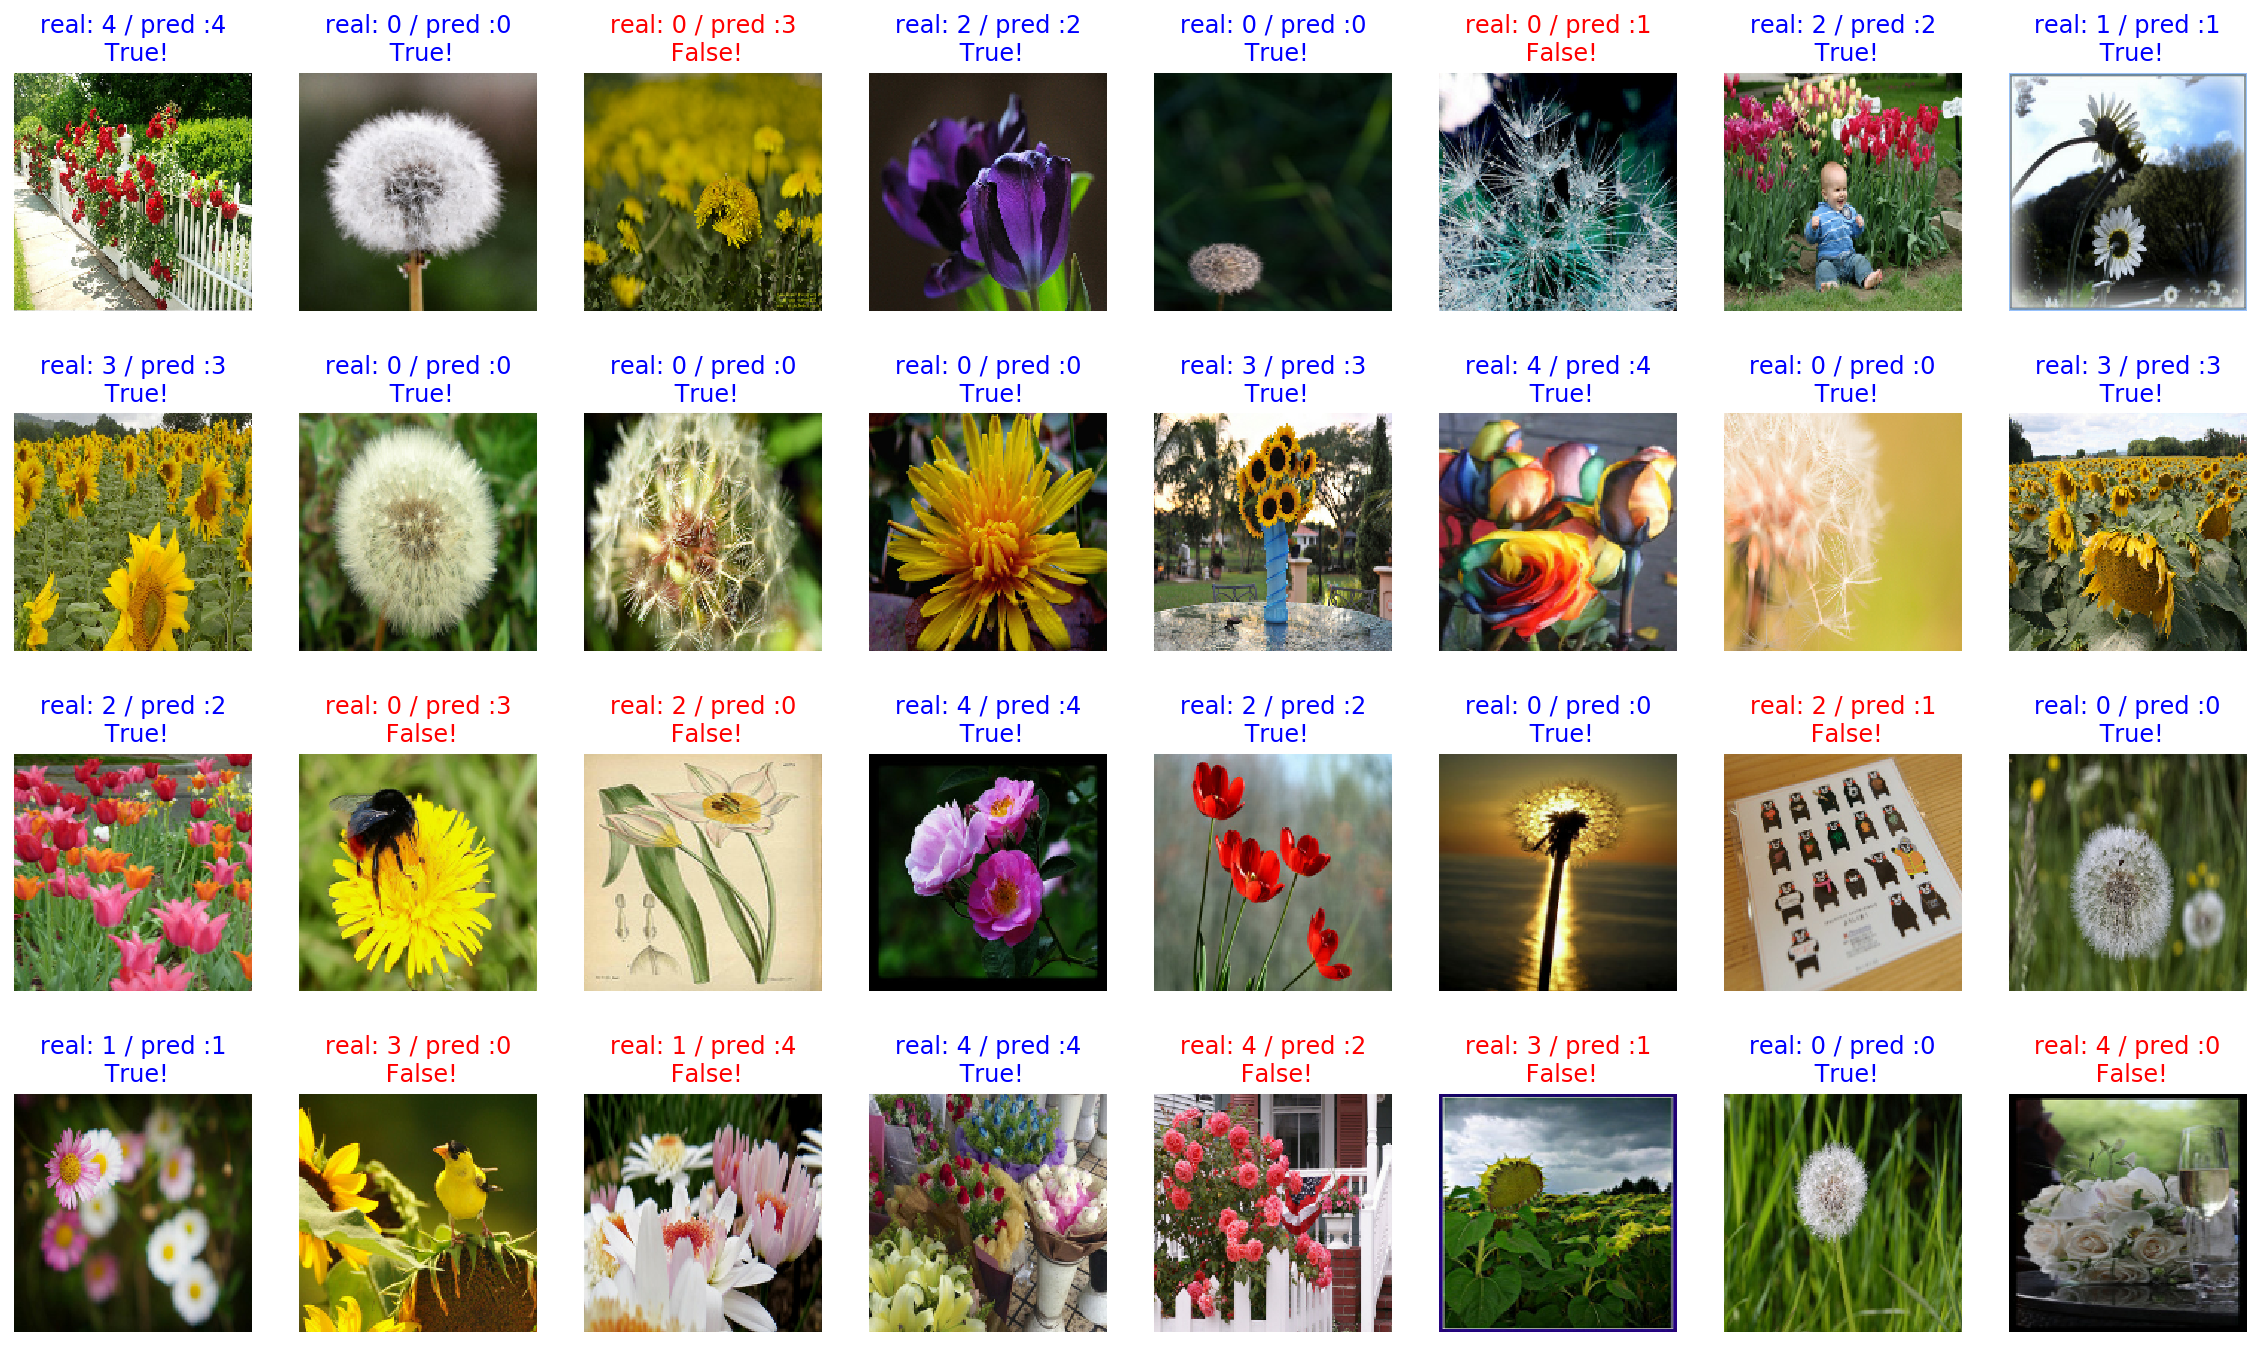

In [48]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [49]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction:
        count+=1
    # [[YOUR CODE]]


print(count / 32 * 100)    # 약 70% 내외

68.75


In [53]:
# 이미지를 폴더에 
img_dir_path = os.getenv("HOME") + "/cat_vs_dog/images"
os.path.exists(img_dir_path)

True

In [54]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

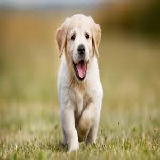

In [55]:
IMG_SIZE = 160
dog_image_path = os.path.join(img_dir_path, 'my_dog.jpeg')

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

In [56]:
import os

checkpoint_dir = os.getenv("HOME") + "/cat_vs_dog/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [57]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

This image seems 0.0% dog, and 100.0% cat.


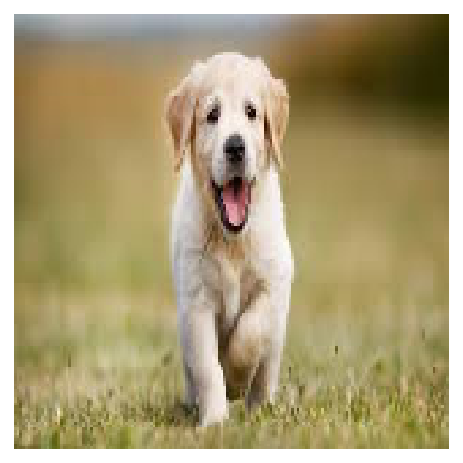

In [58]:
filename = 'my_dog.jpeg'

show_and_predict_image(img_dir_path, filename)

In [59]:
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dog_image.shape # 이미지가 단 한장이라서 1 

(1, 160, 160, 3)

In [60]:
prediction = model.predict(dog_image)
prediction

array([[1., 0., 0., 0., 0.]], dtype=float32)

This image seems 0.0% dog, and 100.0% cat.


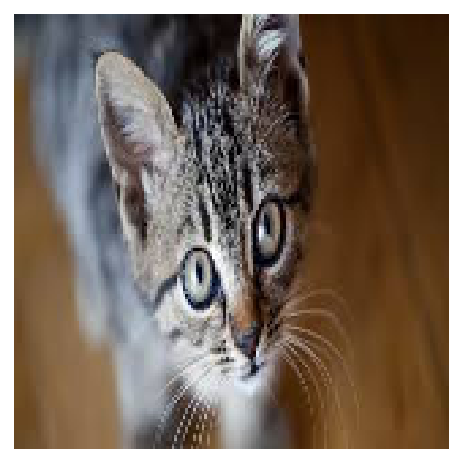

In [61]:
filename = 'my_cat.jpeg'

show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dog, and 0.0% cat.


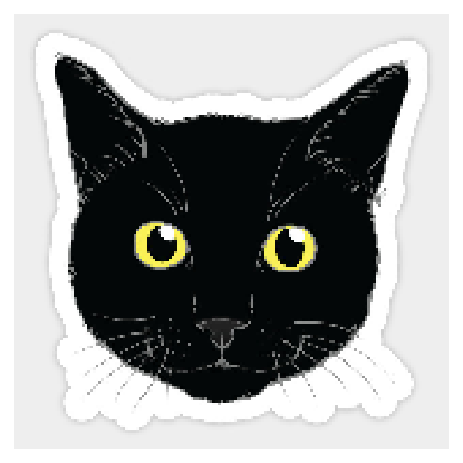

In [62]:
filename = "cat_face.jpg"
show_and_predict_image(img_dir_path, filename)

In [ ]:
강아지 고양이 분류는 잘되는듯하다.
고양이 닮은 사진을 넣었는데 고양이라고 인식을 안하는걸로 봐선.. 
학습데이터 사진에 일반고양이 사진만 있었던거같다...